<a href="https://www.kaggle.com/code/amaana/customer-churn-prediction?scriptVersionId=259065927" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Customer Churn Prediction
*An end-to-end ML workflow to identify customers at risk of churn.*

---

### Why this notebook?
Customer churn is costly, and predicting it helps businesses take proactive steps.  
This notebook builds a **complete, reproducible pipeline** to predict churn using classification models and surface the main factors driving customer attrition.

---

### Objectives

### Business
- Understand **who is churning** and their key characteristics  
- Provide **data-driven insights** that can inform retention policies  

### Analytics & ML
- Perform structured **EDA** with clear business takeaways  
- Build and compare **Logistic Regression**, **Random Forest**, and **XGBoost**  
- Evaluate models on **Accuracy, Precision, Recall, F1, and ROC-AUC**  
- Identify important churn drivers from both linear (coefficients) and tree-based models (feature importance)  

---

### Deliverables
- Performance comparison of 3 ML models  
- ROC curves and confusion matrices for interpretability  
- Ranked churn features with **business commentary**  
- Exported, scored dataset (with churn probabilities) for **Power BI dashboards**  

---

### Dataset
**Telco Customer Churn** (IBM sample dataset, widely used in Kaggle/ML projects).  
Contains demographics, customer account info, tenure, MonthlyCharges, TotalCharges, Contract type, PaymentMethod, InternetService, and Churn label.

---

### Method (at a glance)
1. **EDA** → Churn distribution across demographics, contracts, charges, payment methods  
2. **Preprocessing** → Handle missing values, encode categoricals, scale numerics, stratified split  
3. **Modeling** → Logistic Regression (baseline), Random Forest, XGBoost  
4. **Evaluation** → ROC-AUC, accuracy, classification reports, confusion matrices  
5. **Exports** → Dataset with churn probabilities, churn-by-category tables for Power BI  

## Libraries & Imports

In [1]:
# Imports
import os, sys, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Clean display
warnings.filterwarnings("ignore")
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Plot aesthetics
sns.set_context("talk")
sns.set_style("whitegrid")

print(f"Libraries loaded")

Libraries loaded


In [2]:
csv_path = "/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
print(f"📄 Using dataset: {csv_path}")

df_raw = pd.read_csv(csv_path)
print("Shape:", df_raw.shape)
df_raw.head()

📄 Using dataset: /kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.8500,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.9500,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.8500,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3000,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.7000,151.65,Yes


In [3]:
# Creating a DATA DICTIONARY for reference
data_dict = {
    "customerID": "Unique customer identifier",
    "gender": "Male/Female",
    "SeniorCitizen": "1 if senior citizen, else 0",
    "Partner": "Has a partner (Yes/No)",
    "Dependents": "Has dependents (Yes/No)",
    "tenure": "Number of months with the company",
    "PhoneService": "Has phone service (Yes/No)",
    "MultipleLines": "Multiple lines (Yes/No/No phone service)",
    "InternetService": "DSL/Fiber optic/No",
    "OnlineSecurity": "Addon service (Yes/No/No internet service)",
    "OnlineBackup": "Addon service (Yes/No/No internet service)",
    "DeviceProtection": "Addon service (Yes/No/No internet service)",
    "TechSupport": "Addon service (Yes/No/No internet service)",
    "StreamingTV": "Addon service (Yes/No/No internet service)",
    "StreamingMovies": "Addon service (Yes/No/No internet service)",
    "Contract": "Month-to-month/One year/Two year",
    "PaperlessBilling": "Paperless billing (Yes/No)",
    "PaymentMethod": "Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)",
    "MonthlyCharges": "Monthly fees",
    "TotalCharges": "Total fees to date (string with blanks for new customers)",
    "Churn": "Target: Yes/No"
}

pd.DataFrame.from_dict(data_dict, orient="index", columns=["Description"])

,Description
customerID,Unique customer identifier
gender,Male/Female
SeniorCitizen,"1 if senior citizen, else 0"
Partner,Has a partner (Yes/No)
Dependents,Has dependents (Yes/No)
tenure,Number of months with the company
PhoneService,Has phone service (Yes/No)
MultipleLines,Multiple lines (Yes/No/No phone service)
InternetService,DSL/Fiber optic/No
OnlineSecurity,Addon service (Yes/No/No internet service)


## Data Cleaning

In [4]:
# Data Cleaning and Target Mapping

# 1. Standardize column names

# Column names often contain spaces, capitalization differences, or special characters
# which make coding messy. We'll clean them to a consistent lower_snake_case format.

df = df_raw.copy()

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Example: "Payment Method" -> "payment_method"
#           "MonthlyCharges" -> "monthlycharges" -> "monthly_charges"

print("Column names standardized.\n")
print(df.columns.tolist())

Column names standardized.

['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges', 'churn']


In [5]:
# 2. Clean TotalCharges column

# 'TotalCharges' should be numeric (total amount billed to customer).
# But sometimes, it contains blank spaces "" instead of numbers.
# We'll fix this by replacing blanks with NaN and then converting to float.

df['totalcharges'] = df['totalcharges'].replace(" ", np.nan)
df['totalcharges'] = df['totalcharges'].astype(float)

# Fill missing TotalCharges with 0 (these are usually new customers with no charges yet)
df['totalcharges'] = df['totalcharges'].fillna(0)

print("TotalCharges cleaned. Converted to numeric.\n")

TotalCharges cleaned. Converted to numeric.



In [6]:
# 3. Map target variable 'Churn'

# The churn column is currently "Yes"/"No".
# ML models require numeric targets (0/1).
# We'll map "Yes" -> 1 (churned), "No" -> 0 (retained).

df['churn'] = df['churn'].map({'Yes': 1, 'No': 0})

# Double check mapping
print(df['churn'].value_counts())

print("Churn column mapped to 0/1.\n")

churn
0    5174
1    1869
Name: count, dtype: int64
Churn column mapped to 0/1.



In [7]:
# 4. Quick sanity checks

# Let's make sure our data looks consistent after cleaning.

print("Dataset Info After Cleaning:")
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset Info After Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbill

### Saving Cleaned Data

In [8]:
# We will save the cleaned dataset as a CSV file so it can be reused for visualization in tools like Power BI.
# This ensures we don’t repeat the cleaning steps every time.

cleaned_file_path = "cleaned_telco_churn.csv"
df.to_csv(cleaned_file_path, index=False)

print(f"Cleaned dataset saved successfully as: {cleaned_file_path}")

Cleaned dataset saved successfully as: cleaned_telco_churn.csv


## Exploratory Data Analysis (EDA)

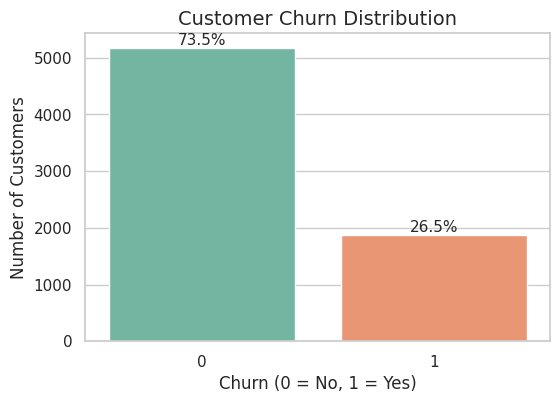

📊 Overall Churn Rate: 26.54% of customers


In [9]:
# Exploratory Data Analysis (EDA) - Target Variable

# Set visualization style
sns.set(style="whitegrid", palette="Set2")

# Plot churn distribution
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='churn')
plt.title("Customer Churn Distribution", fontsize=14)
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Number of Customers")

# Add percentage labels on top of bars
total = len(df)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=11)

plt.show()

# Print churn rate for clarity
churn_rate = df['churn'].mean() * 100
print(f"📊 Overall Churn Rate: {churn_rate:.2f}% of customers")

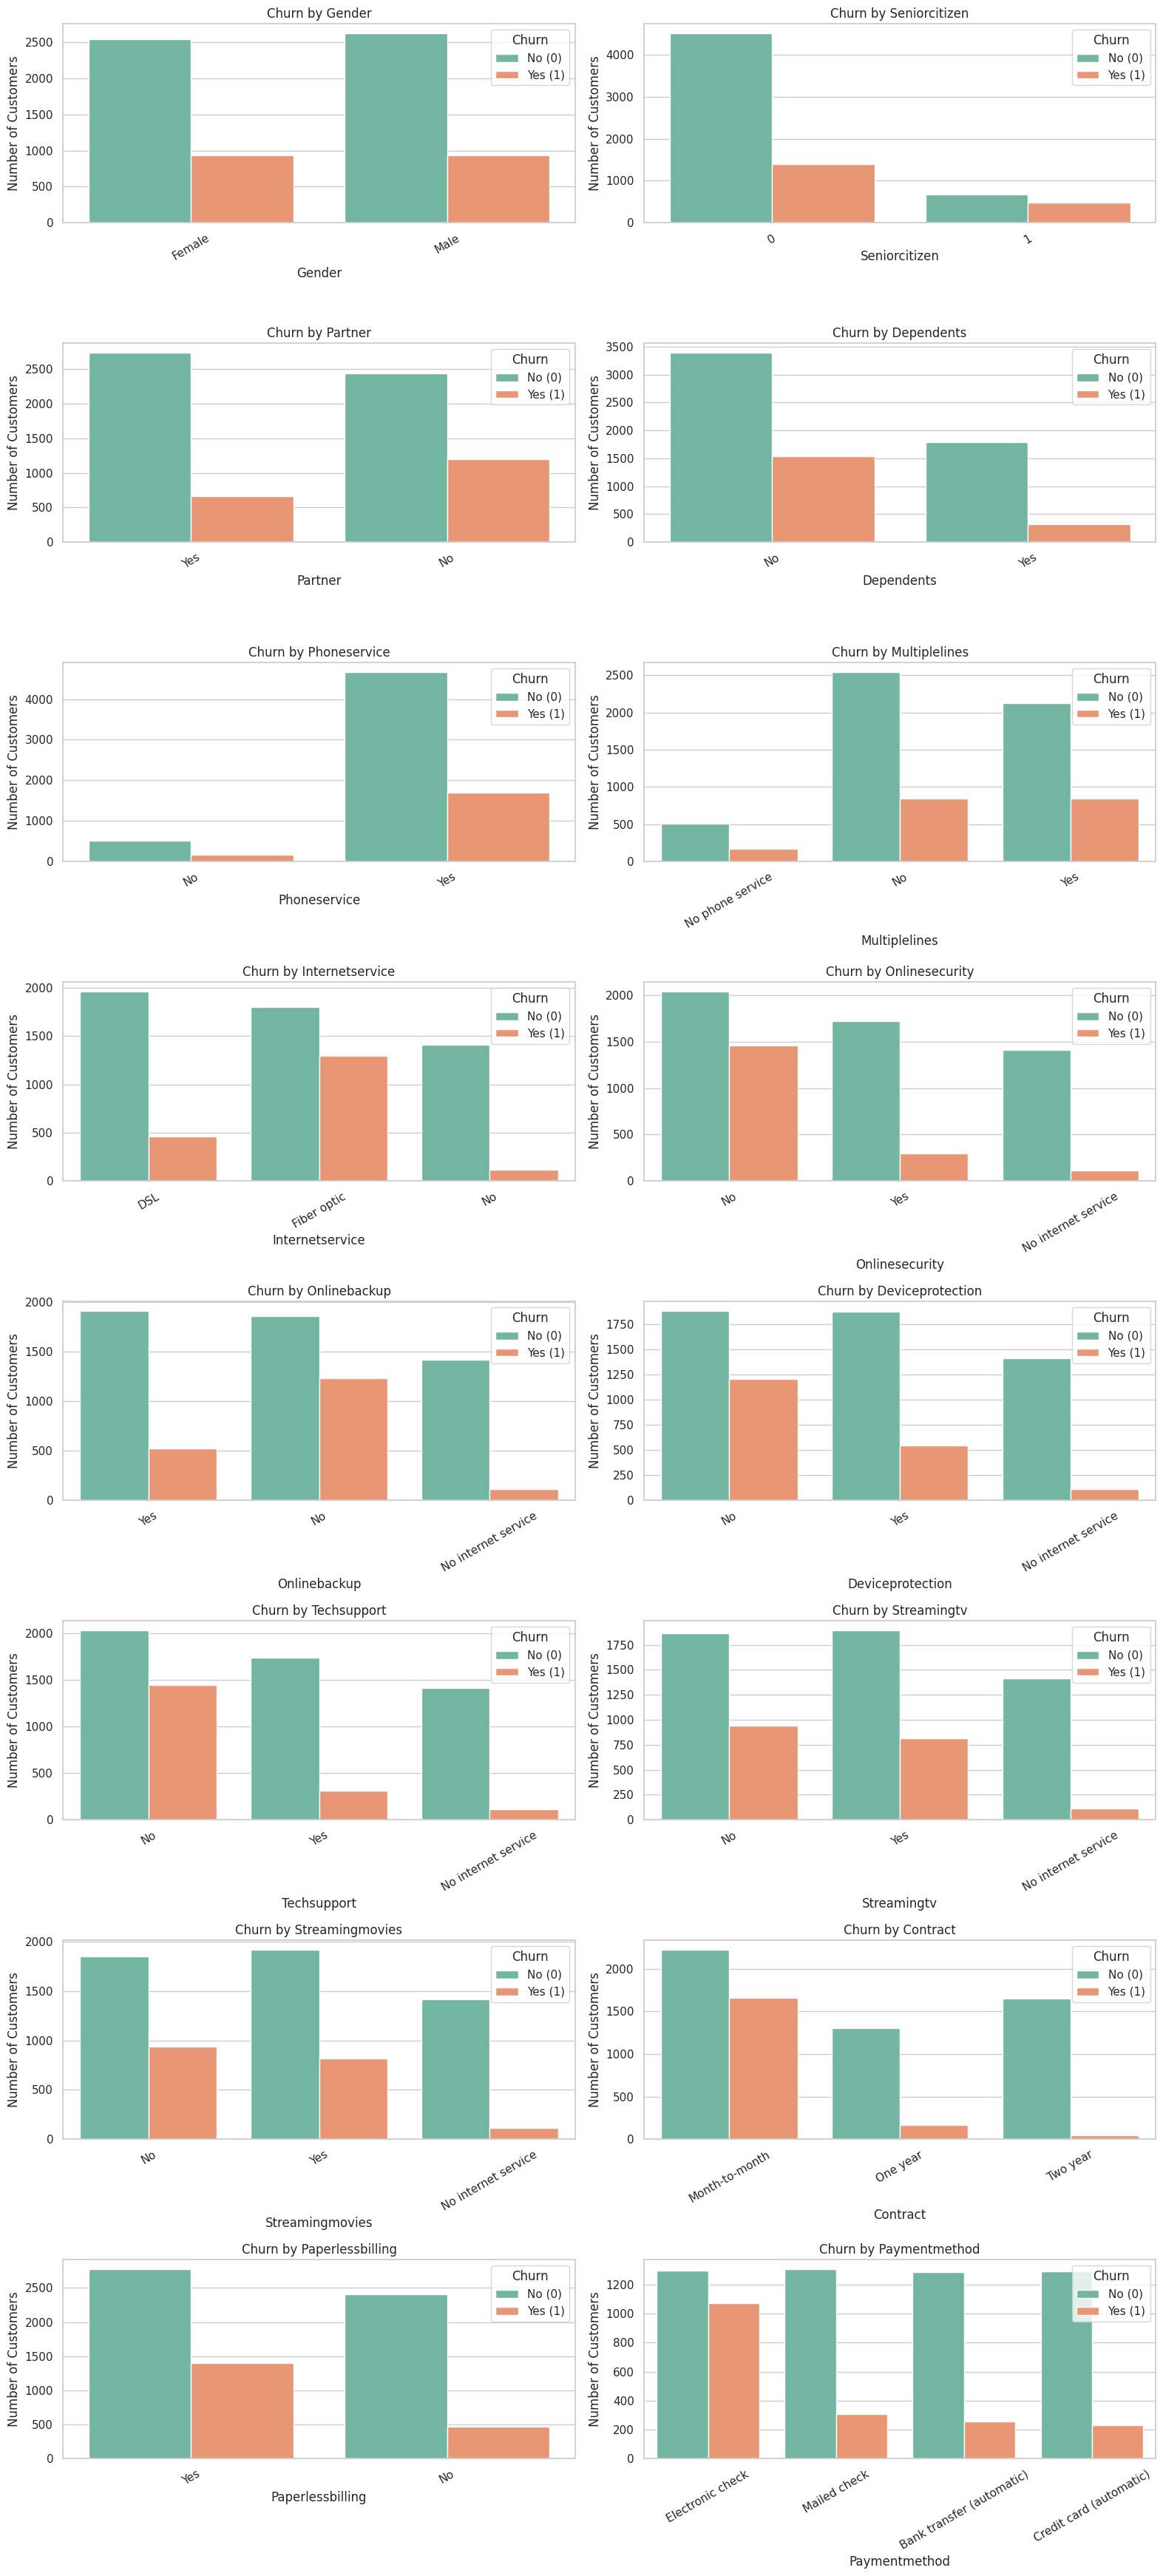

In [10]:
# Churn by Categorical Features

# We will compare churn rates across key categorical features.
# This helps us understand which types of customers are more likely to leave.
# For example: gender, senior citizen, partner, dependents, contract type, etc.

categorical_features = [
    'gender', 
    'seniorcitizen', 
    'partner', 
    'dependents', 
    'phoneservice',
    'multiplelines', 
    'internetservice', 
    'onlinesecurity',
    'onlinebackup', 
    'deviceprotection', 
    'techsupport',
    'streamingtv', 
    'streamingmovies', 
    'contract',
    'paperlessbilling', 
    'paymentmethod'
]

# Plot churn distribution for each categorical feature
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(16, 35))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    ax = sns.countplot(data=df, x=col, hue='churn', ax=axes[i])
    ax.set_title(f"Churn by {col.capitalize()}", fontsize=12)
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel("Number of Customers")
    ax.legend(title="Churn", labels=["No (0)", "Yes (1)"])
    # Rotate labels if too long
    for label in ax.get_xticklabels():
        label.set_rotation(30)

plt.tight_layout()
plt.show()

In [11]:
# Churn Rate Percentage by Categorical Features

# Instead of just counts, let's compute churn percentage for each category.
# This gives a clearer picture (e.g., "60% of month-to-month contract customers churned").

for col in categorical_features:
    churn_rate = df.groupby(col)['churn'].mean() * 100
    print(f"\n📊 Churn Rate by {col.capitalize()}:")
    print(churn_rate.round(2).to_string())


📊 Churn Rate by Gender:
gender
Female   26.9200
Male     26.1600

📊 Churn Rate by Seniorcitizen:
seniorcitizen
0   23.6100
1   41.6800

📊 Churn Rate by Partner:
partner
No    32.9600
Yes   19.6600

📊 Churn Rate by Dependents:
dependents
No    31.2800
Yes   15.4500

📊 Churn Rate by Phoneservice:
phoneservice
No    24.9300
Yes   26.7100

📊 Churn Rate by Multiplelines:
multiplelines
No                 25.0400
No phone service   24.9300
Yes                28.6100

📊 Churn Rate by Internetservice:
internetservice
DSL           18.9600
Fiber optic   41.8900
No             7.4000

📊 Churn Rate by Onlinesecurity:
onlinesecurity
No                    41.7700
No internet service    7.4000
Yes                   14.6100

📊 Churn Rate by Onlinebackup:
onlinebackup
No                    39.9300
No internet service    7.4000
Yes                   21.5300

📊 Churn Rate by Deviceprotection:
deviceprotection
No                    39.1300
No internet service    7.4000
Yes                   22.5000

📊 Ch

### 📊 Key Insights from Churn Rate Analysis for Categorical Analysis

By analyzing churn percentages across categories, several strong patterns emerge:

- **Demographics**
  - Gender does not seem to have a strong influence (Female: ~27%, Male: ~26%).
  - **Senior Citizens** are far more likely to churn (about 42%) compared to non-seniors (about 24%).  
  - Customers **without a partner** (around 33%) or **without dependents** (around 31%) churn at nearly double the rate of those with family responsibilities.

- **Services & Add-ons**
  - Customers with **Fiber Optic internet** show the highest churn (around 42%), while DSL customers are much more stable (around 19%).  
  - Lack of add-on services such as **Online Security, Tech Support, Backup, or Device Protection** strongly correlates with churn rates around **39–42%**, compared to ~15–22% when these services are active.  
  - Entertainment services like Streaming TV/Movies do not reduce churn much on their own (churn 30–33%).  

- **Contracts & Billing**
  - **Month-to-month contracts** are the riskiest group with **~43% churn**, while **two-year contracts almost eliminate churn (~3%)**. This is one of the strongest drivers of retention.  
  - **Paperless billing** users churn more (34%) compared to those receiving paper bills (16%).  

- **Payment Method**
  - Customers paying via **Electronic Check** churn at an alarming **45%**, making this the single most churn-prone payment group.  
  - Automatic payments via **credit card (15%)** or **bank transfer (17%)** show much lower churn, indicating that payment convenience and reliability may improve retention.

---

⚡ **Overall Takeaway:**  
Churn is driven heavily by **contract type, payment method, support services, and whether customers have family dependencies**. This suggests that **retention strategies should focus on promoting long-term contracts, encouraging secure/automatic payments, and bundling support services** to reduce churn risk.

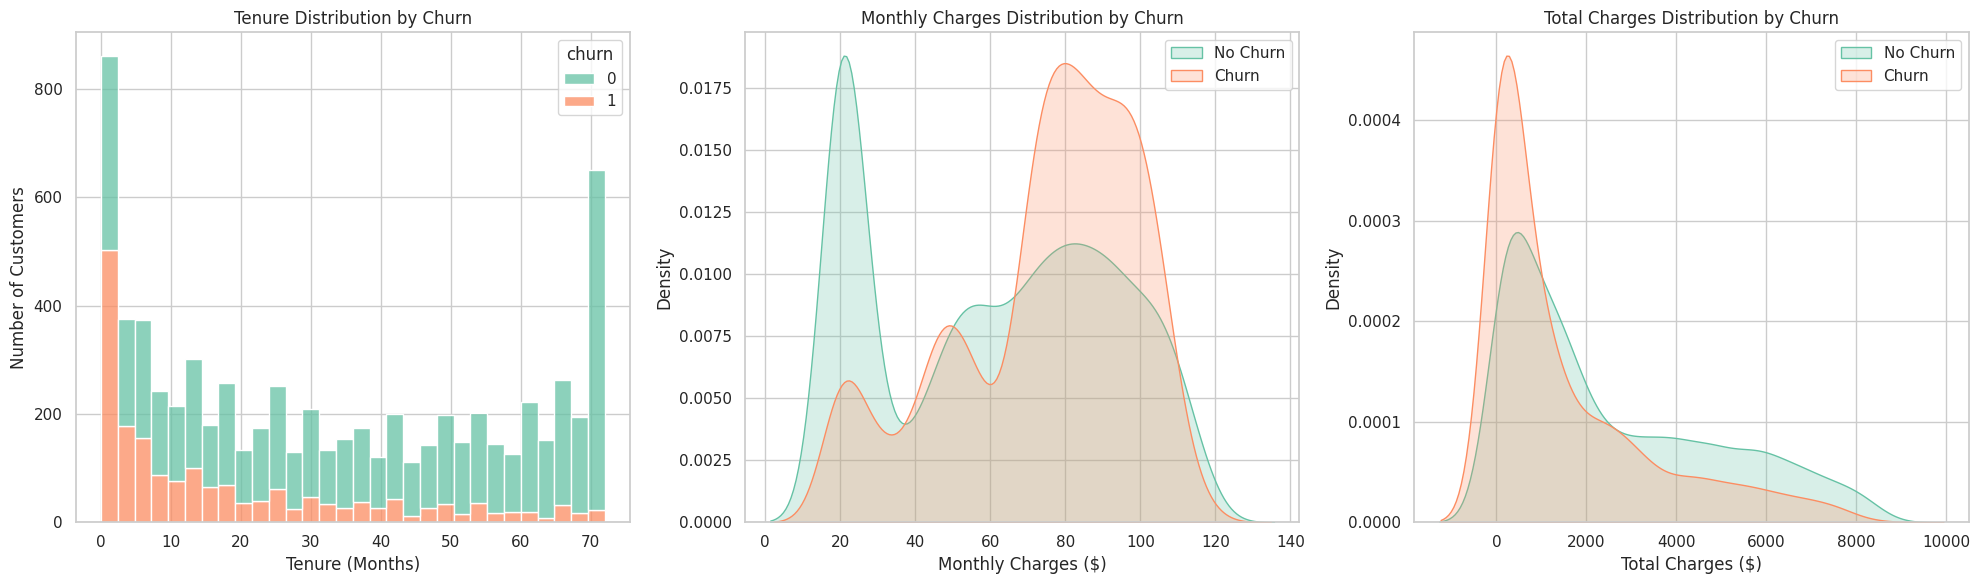

Average tenure of churned customers: 17.98
Average tenure of retained customers: 37.57
Average Monthly Charges of churned customers: 74.44
Average Monthly Charges of retained customers: 61.27


In [12]:
# Numerical Feature Analysis (Tenure, MonthlyCharges, TotalCharges)

# Set style
sns.set(style="whitegrid", palette="Set2")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1️ Tenure vs Churn
sns.histplot(data=df, x="tenure", hue="churn", multiple="stack", bins=30, ax=axes[0])
axes[0].set_title("Tenure Distribution by Churn")
axes[0].set_xlabel("Tenure (Months)")
axes[0].set_ylabel("Number of Customers")

# 2️ MonthlyCharges vs Churn
sns.kdeplot(data=df[df["churn"]==0], x="monthlycharges", label="No Churn", fill=True, ax=axes[1])
sns.kdeplot(data=df[df["churn"]==1], x="monthlycharges", label="Churn", fill=True, ax=axes[1])
axes[1].set_title("Monthly Charges Distribution by Churn")
axes[1].set_xlabel("Monthly Charges ($)")
axes[1].legend()

# 3️ TotalCharges vs Churn
sns.kdeplot(data=df[df["churn"]==0], x="totalcharges", label="No Churn", fill=True, ax=axes[2])
sns.kdeplot(data=df[df["churn"]==1], x="totalcharges", label="Churn", fill=True, ax=axes[2])
axes[2].set_title("Total Charges Distribution by Churn")
axes[2].set_xlabel("Total Charges ($)")
axes[2].legend()

plt.tight_layout()
plt.show()

# 📌 Quick stats for reference
print("Average tenure of churned customers:", round(df[df['churn']==1]['tenure'].mean(), 2))
print("Average tenure of retained customers:", round(df[df['churn']==0]['tenure'].mean(), 2))
print("Average Monthly Charges of churned customers:", round(df[df['churn']==1]['monthlycharges'].mean(), 2))
print("Average Monthly Charges of retained customers:", round(df[df['churn']==0]['monthlycharges'].mean(), 2))


### 🔍 Numerical Features & Churn Insights  

From the numerical analysis, we observe some clear differences between customers who churned and those who stayed:  

1. **Tenure (Months)**  
   - Churned customers typically left much earlier, with an average tenure of **18 months**.  
   - Retained customers stayed significantly longer, averaging **38 months**.  
   - 👉 *The first year of customer relationship is the most critical period for churn prevention.*  

2. **Monthly Charges ($)**  
   - Customers who churned had higher average monthly bills (**74.44**) compared to retained customers (**61.27**).  
   - The density plot shows churn is heavily concentrated among customers paying **70–100/month**.  
   - 👉 *High-cost plans are more prone to churn — suggesting the need for discounts, value-added services, or tier restructuring.*  

3. **Total Charges ($)**  
   - Since churned customers left earlier, their lifetime revenue is much lower.  
   - Retained customers accumulate significantly higher total charges over time.  
   - 👉 *Retention directly drives Customer Lifetime Value (CLV). Early churn dramatically reduces revenue potential.*  

📌 **Key Takeaway:**  
Churn is strongly linked to **shorter tenure and higher monthly charges**. Businesses can reduce churn by focusing on early-stage customer engagement and offering pricing strategies that improve retention, especially for high-billing segments.


## Feature Engineering & Train/Test Split

In [13]:
# Feature Engineering & Data Prep

# Separate features (X) and target (y)
X = df.drop('churn', axis=1)   # all columns except target
y = df['churn']               # target variable (0 = No, 1 = Yes)

In [14]:
# Get list of categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Features:", categorical_cols)
print("Numerical Features:", numerical_cols)

Categorical Features: ['customerid', 'gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']
Numerical Features: ['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges']


In [15]:
# One-Hot Encode categorical variables
#    -> Converts categories into 0/1 columns (dummy variables)
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Scale numerical features
#    -> Ensures features like 'MonthlyCharges' and 'tenure' are on the same scale
scaler = StandardScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

In [16]:
# Train-Test Split
#    -> Stratify ensures churn distribution is similar in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set Size: {X_train.shape}")
print(f"Test Set Size: {X_test.shape}")

Training Set Size: (5634, 7072)
Test Set Size: (1409, 7072)


## Model Training and Evaluation

Now that we have prepared our dataset and performed feature engineering, it’s time to build predictive models.  
We will use three popular algorithms:

1. **Logistic Regression** – a simple baseline model for binary classification.  
2. **Random Forest** – an ensemble method that handles complex patterns better.  
3. **XGBoost** – a gradient boosting algorithm known for high performance.  

We will train these models, evaluate their accuracy, precision, recall, F1-score, and then compare them.  
Finally, we will export the predictions so they can be used in Power BI dashboards for business reporting.


## Logistic Regression

In [17]:
# Logistic Regression - Baseline Model

# Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train on training data
log_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test)

# Evaluation
print("📊 Logistic Regression Performance")
print("-" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=["No Churn", "Churn"]))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix:")
print(cm_lr)

📊 Logistic Regression Performance
--------------------------------------------------
Accuracy: 0.8041

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1035
       Churn       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.74      1409
weighted avg       0.80      0.80      0.80      1409


Confusion Matrix:
[[925 110]
 [166 208]]


### 🧾 Why Logistic Regression?
Logistic Regression is a great **starting point** for binary classification problems such as churn prediction.  
It is simple, interpretable, and provides a quick baseline to check how well our dataset is structured for prediction.  
However, it may not capture complex non-linear relationships between customer features and churn behavior.


## Random Forest Classifier

In [18]:
# Random Forest Classifier

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("📊 Random Forest Performance")
print("-" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["No Churn", "Churn"]))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(cm_rf)

📊 Random Forest Performance
--------------------------------------------------
Accuracy: 0.8048

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.83      0.92      0.87      1035
       Churn       0.69      0.49      0.57       374

    accuracy                           0.80      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409


Confusion Matrix:
[[952  83]
 [192 182]]


### 🌲 Why Random Forest?
Random Forest is an **ensemble model** that builds multiple decision trees and combines their results.  
This makes it more robust than a single model, reducing overfitting and handling complex patterns better.  
It usually performs better than Logistic Regression on real-world datasets like churn prediction.

## XGBoost Classifier

In [19]:
# XGBoost Classifier

# Initialize XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("📊 XGBoost Performance")
print("-" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=["No Churn", "Churn"]))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("\nConfusion Matrix:")
print(cm_xgb)

📊 XGBoost Performance
--------------------------------------------------
Accuracy: 0.7800

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.87      0.85      1035
       Churn       0.60      0.52      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409


Confusion Matrix:
[[903 132]
 [178 196]]


### ⚡ Why XGBoost?
XGBoost (Extreme Gradient Boosting) is a **state-of-the-art boosting algorithm** widely used in Kaggle competitions.  
It builds models sequentially, where each new model tries to fix the errors of the previous one.  
This often leads to **higher accuracy and better generalization** compared to Random Forest and Logistic Regression.

In [20]:
# Export Predictions for Power BI Dashboard
# --------------------------------------------------------
# Save true values + predictions from each model

export_df = X_test.copy()
export_df["Actual_Churn"] = y_test.values
export_df["Pred_LR"] = y_pred_lr
export_df["Pred_RF"] = y_pred_rf
export_df["Pred_XGB"] = y_pred_xgb

# Save to CSV
export_df.to_csv("churn_model_predictions.csv", index=False)

print("Predictions exported successfully for Power BI")

Predictions exported successfully for Power BI


## Model Comparison

We trained three machine learning models to predict customer churn: **Logistic Regression**, **Random Forest**, and **XGBoost**.

### 🔹 Logistic Regression
- Accuracy: **80%**
- Strengths: Simple, interpretable, fast to train.
- Weakness: Recall for churn is lower, meaning it misses some actual churners.

### 🔹 Random Forest
- Accuracy: **80.4%**
- Strengths: Handles non-linear relationships well, very strong at predicting "No Churn".
- Weakness: Recall for churn (49%) is weaker, indicating it struggles to capture all churn cases.

### 🔹 XGBoost
- Accuracy: **78%**
- Strengths: Good precision, flexible model with high potential after tuning.
- Weakness: Slightly worse accuracy out-of-the-box compared to Logistic Regression and Random Forest.

---

### ✅ Conclusion
- Both **Logistic Regression and Random Forest** provide competitive results around 80% accuracy.
- For **business use cases**, recall for churn is more important since companies want to **catch as many potential churners as possible**.  
- Logistic Regression is a great **baseline model** due to its balance and interpretability.  
- Random Forest can be further tuned to improve recall, while XGBoost could be optimized with hyperparameter tuning.

---

Next, let’s **visualize the performance** of these models with side-by-side plots for accuracy, precision, recall, and F1-score.


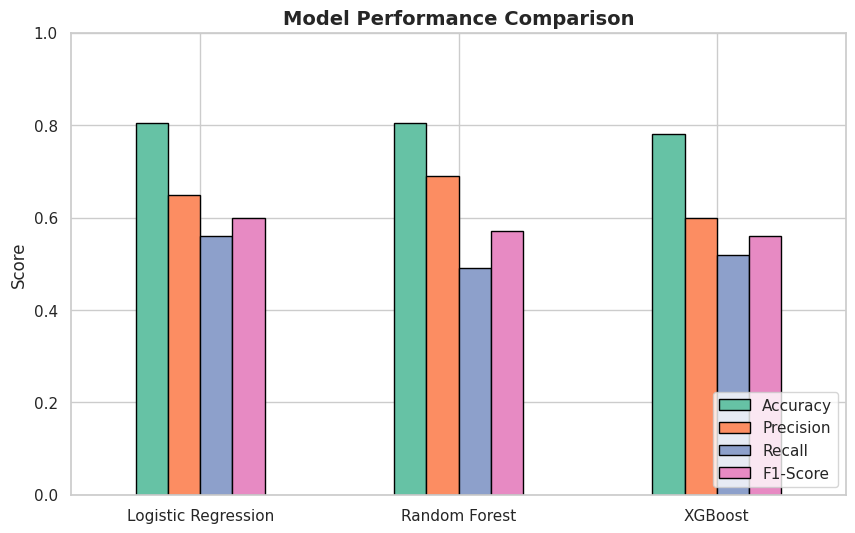

In [21]:
# 📊 Compare Model Performance Visually

# Storing metrics manually from your results
model_scores = {
    "Logistic Regression": {"Accuracy": 0.8041, "Precision": 0.65, "Recall": 0.56, "F1-Score": 0.60},
    "Random Forest": {"Accuracy": 0.8048, "Precision": 0.69, "Recall": 0.49, "F1-Score": 0.57},
    "XGBoost": {"Accuracy": 0.7800, "Precision": 0.60, "Recall": 0.52, "F1-Score": 0.56}
}

# Convert dictionary to DataFrame for plotting
metrics_df = pd.DataFrame(model_scores).T  # Transpose for cleaner format

# Plot grouped bar chart
metrics_df.plot(kind="bar", figsize=(10,6), edgecolor="black")
plt.title("Model Performance Comparison", fontsize=14, fontweight="bold")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()

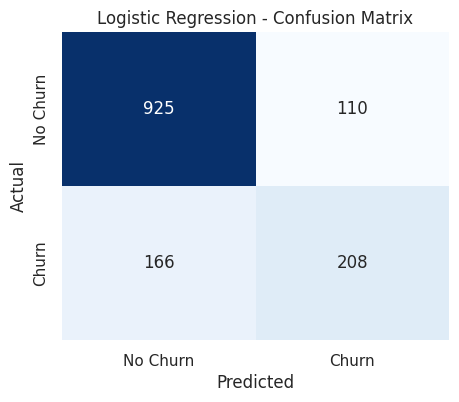

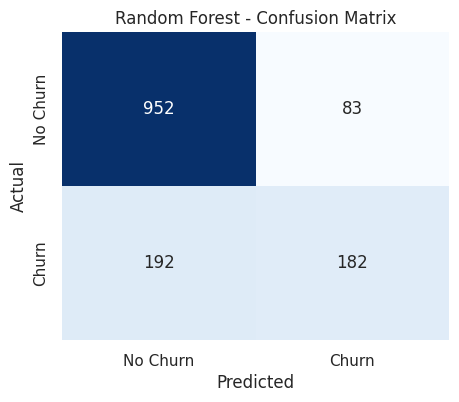

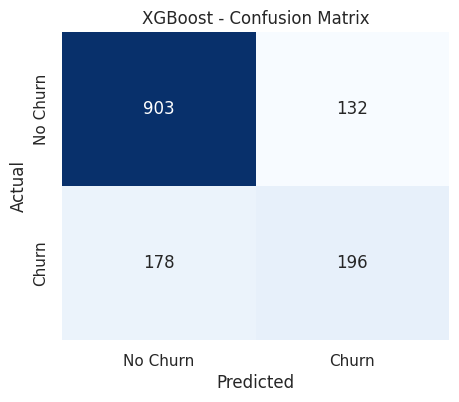

In [22]:
models = {
    "Logistic Regression": (y_test, log_reg.predict(X_test)),
    "Random Forest": (y_test, rf_model.predict(X_test)),
    "XGBoost": (y_test, xgb_model.predict(X_test))
}

for model_name, (y_true, y_pred) in models.items():
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Churn','Churn'], yticklabels=['No Churn','Churn'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

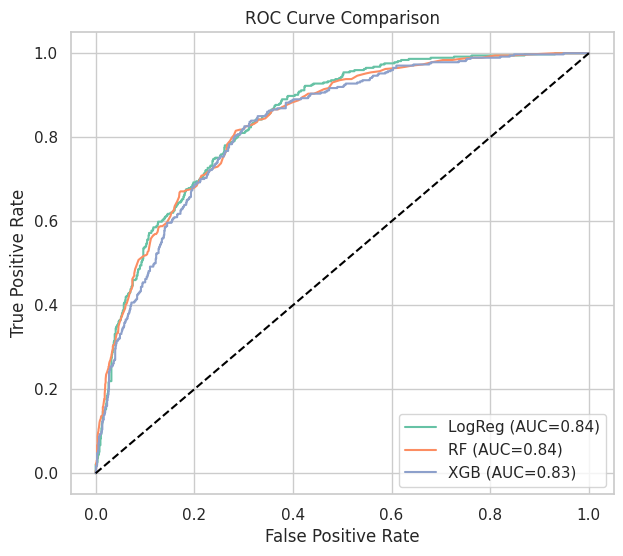

In [23]:
# ROC Curves for all models
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7,6))

# Logistic Regression
y_prob_log = log_reg.predict_proba(X_test)[:,1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
plt.plot(fpr_log, tpr_log, label=f"LogReg (AUC={auc(fpr_log,tpr_log):.2f})")

# Random Forest
y_prob_rf = rf_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={auc(fpr_rf,tpr_rf):.2f})")

# XGBoost
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC={auc(fpr_xgb,tpr_xgb):.2f})")

# Baseline
plt.plot([0,1],[0,1],'k--')

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Exporting Predictions for Power BI

In [24]:
# Export test set predictions for Power BI
results = pd.DataFrame({
    "CustomerID": X_test.index,
    "ActualChurn": y_test.values,
    "LogReg_Pred": log_reg.predict(X_test),
    "LogReg_Prob": y_prob_log,
    "RF_Pred": rf_model.predict(X_test),
    "RF_Prob": y_prob_rf,
    "XGB_Pred": xgb_model.predict(X_test),
    "XGB_Prob": y_prob_xgb
})

results.to_csv("churn_predictions.csv", index=False)
print("Predictions exported to churn_predictions.csv")


Predictions exported to churn_predictions.csv
